In [2]:
import os

import numpy as np

import matplotlib.pyplot as plt

from skimage import io, color, data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import PatchExtractor

from itertools import chain  

import joblib

from TIPEutils import sliding_window

model_patches_shape = (62, 47)

# Chargement du modèle à améliorer
filename = 'temp_model.sav'
loaded_model = joblib.load(filename)

### Le modèle de base n'a pas été entraîné avec les mêmes imgs_to_use -> le réentrainer avant même de faire du HNM

In [73]:
imgs_to_use = ['brick', 'text', 'moon', 'grass', 'gravel',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field', 'cell']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=model_patches_shape):
    ''' Extrait des patches d'une image
    '''
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negatives_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

<ipython-input-73-ae1600b05197>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


In [76]:
len(negatives_patches)

36000

[34751 32262  8250 ... 19700  1922 32263]


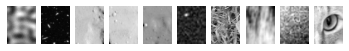

In [77]:
sample_size = 36000
sample_indices = np.random.permutation(negatives_patches.shape[0])[:sample_size]
print(sample_indices)
sample = negatives_patches[sample_indices]

fig, axs = plt.subplots(1, 10)
for i in range(10):
    axs[i].imshow(sample[i], cmap='gray')
    axs[i].axis('off')

56 hard negative examples
HNE 0
HNE 1
HNE 2
HNE 3
HNE 4
HNE 5
HNE 6
HNE 7
HNE 8
HNE 9
HNE 10
HNE 11
HNE 12
HNE 13
HNE 14
HNE 15
HNE 16
HNE 17
HNE 18
HNE 19
HNE 20
HNE 21


<ipython-input-78-52d8e5e56deb>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


HNE 22
HNE 23
HNE 24
HNE 25
HNE 26
HNE 27
HNE 28
HNE 29
HNE 30
HNE 31
HNE 32
HNE 33
HNE 34
HNE 35
HNE 36
HNE 37
HNE 38
HNE 39
HNE 40
HNE 41
HNE 42
HNE 43
HNE 44
HNE 45
HNE 46
HNE 47
HNE 48
HNE 49
HNE 50
HNE 51
HNE 52
HNE 53
HNE 54
HNE 55


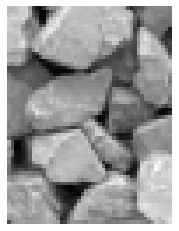

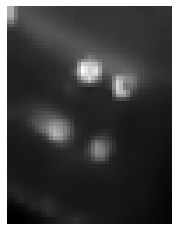

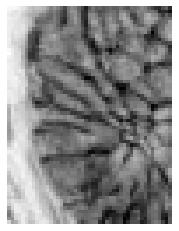

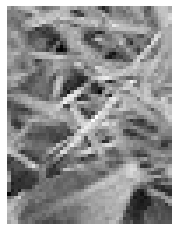

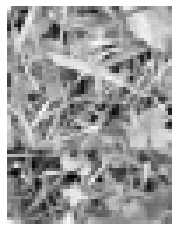

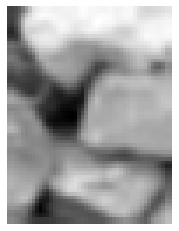

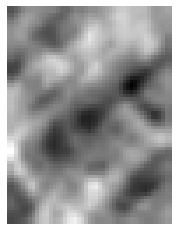

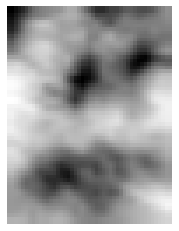

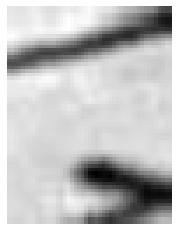

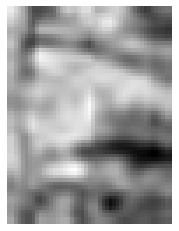

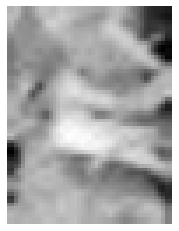

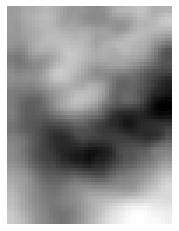

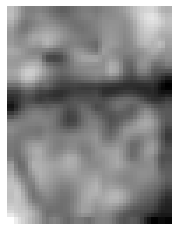

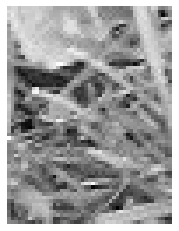

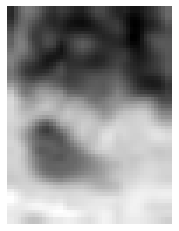

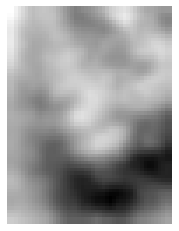

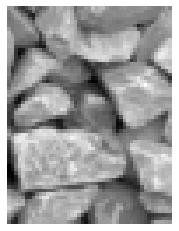

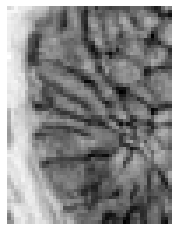

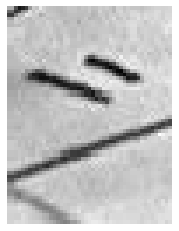

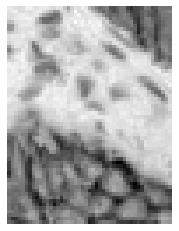

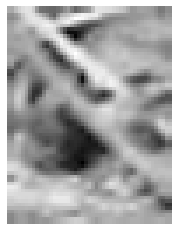

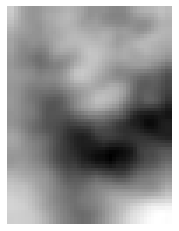

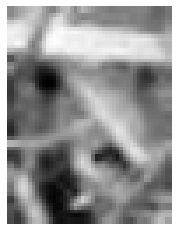

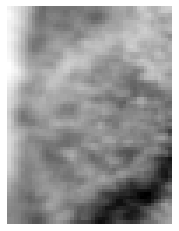

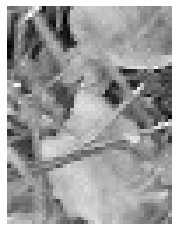

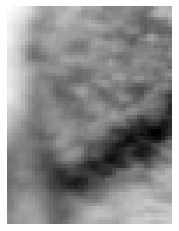

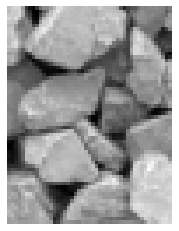

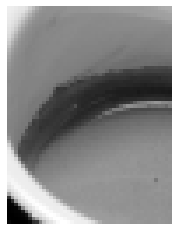

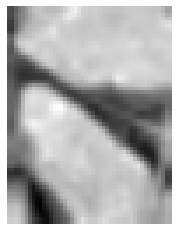

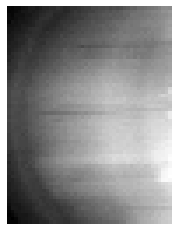

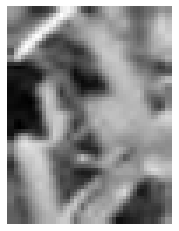

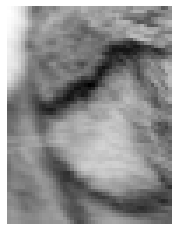

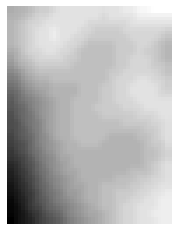

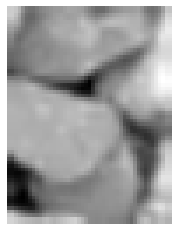

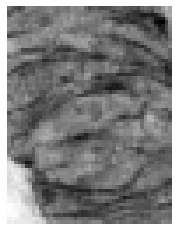

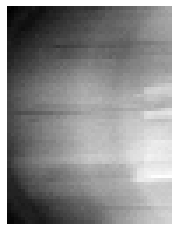

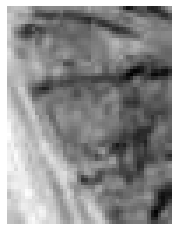

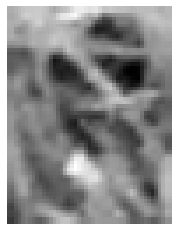

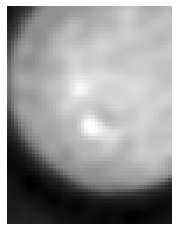

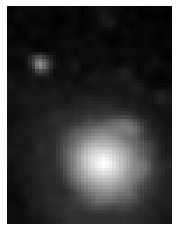

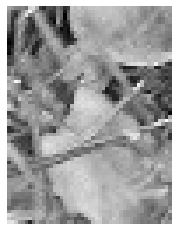

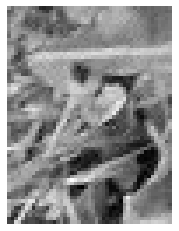

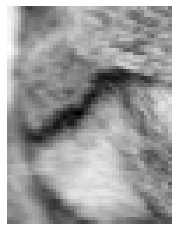

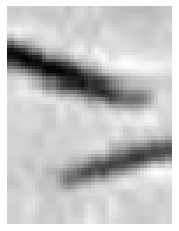

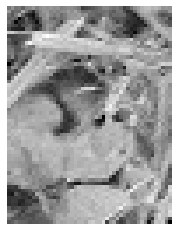

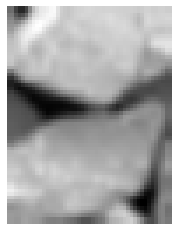

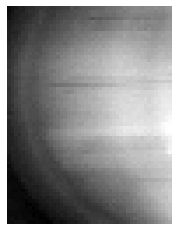

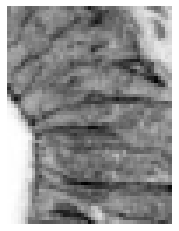

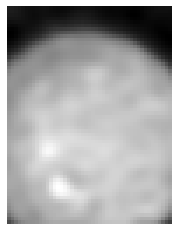

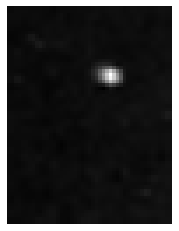

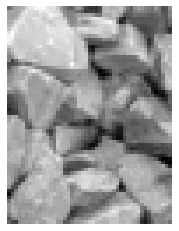

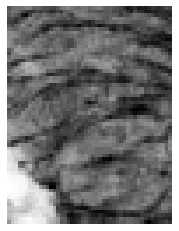

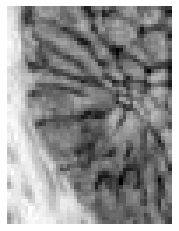

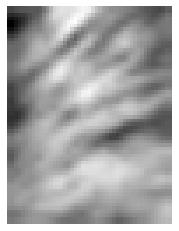

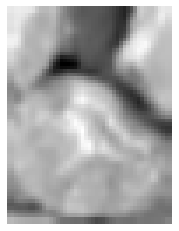

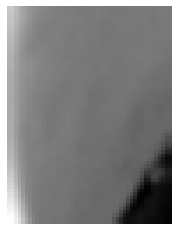

In [78]:
patches_hog = np.array([hog(patch) for patch in sample])

labels = loaded_model.predict(patches_hog)

hard_negatives = []
hard_negatives_indices = []

for k in range(len(sample)):
    if labels[k]:
        hard_negatives.append(sample[k])
        hard_negatives_indices.append(sample_indices[k])
        
hard_negatives_indices = np.array(hard_negatives_indices)

print("{} hard negative examples".format(len(hard_negatives_indices)))

'''
fig, axs = plt.subplots(1, len(hard_negatives_indices))
for (k, i) in enumerate(hard_negatives_indices):
    axs[k].imshow(negatives_patches[i], cmap='gray')
    axs[k].axis('off')
'''

for (k, i) in enumerate(hard_negatives_indices):
    fig, ax = plt.subplots()
    print("HNE {}".format(k))
    ax.imshow(negatives_patches[i], cmap='gray')
    ax.axis('off')

La prochaine étape est donc d'entrainer un nouveau SVM avec comme positives examples: les premiers positives examples union ces hard negative examples et comme negatives examples: les premiers negatives examples.